tb - 6/25/2022 - Goal is to test whether simple diffusion & (sequential feature selection with polynomial fits) work better when phrased using climate-invariant inputs

# Imports and initialization

## Imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures

from cbrain.cam_constants import *
from cbrain.climate_invariant import *
from cbrain.preprocessing.convert_dataset_20191113 import compute_LHF_nsDELQ
from cbrain.climate_invariant_utils import *
from scipy.integrate import cumtrapz,trapz
from scipy import interpolate,misc

import matplotlib.pyplot as plt
import numpy as np
import pickle
import xarray as xr

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


## Load data

### Load training and test datasets

In [2]:
scale_dict = pickle.load(open('/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'+'scale_dicts/009_Wm2_scaling.pkl','rb'))

In [3]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'

In [4]:
path_train_both = path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc'
path_RH_B = path_data+'2022_06_26_B_RH_both.nc'

In [5]:
climates = ['m4K','ref','p4K']
path_append = ['2021_03_18_O3_TEST_M4K.nc','2021_01_24_O3_TEST.nc','2021_03_18_O3_TEST_P4K.nc']
path_RH_B_append = ['2022_06_27_B_RH_TEST_m4K.nc','2022_06_27_B_RH_TEST_ref.nc','2022_06_27_B_RH_TEST_p4K.nc']
path_LHF_nsDELQ = '2022_06_29_LHF_nsDELQ.nc'

In [6]:
LHF_nsDELQ = xr.open_dataset(path_data+path_LHF_nsDELQ)

In [7]:
train_both = xr.open_dataset(path_train_both)
train_both_RH_B = xr.open_dataset(path_RH_B)

In [8]:
test_sets = {}; test_sets_RHB = {}; 
LHFname = ['LHFns_cold','LHFns_med','LHFns_hot']

In [9]:
for iclim,clim in enumerate(climates):
    test_sets[clim] = xr.open_dataset(path_data+path_append[iclim])
    test_sets_RHB[clim] = xr.open_dataset(path_data+path_RH_B_append[iclim])

In [10]:
print(train_both['var_names'].values)

['QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP'
 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP'
 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'QBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP'
 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP'
 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP' 'TBP'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA' 'O3_AQUA'
 'O3_AQUA' 'O3_AQUA' 'PS' 'SOLIN' 'SHFLX' 'LHFLX' 'PHQ' 'PHQ' 'PHQ' 'PHQ'
 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ'
 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ' 'PHQ'
 'PHQ' 'PHQ' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND'
 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYSTND' 'TPHYST

In [11]:
ind_input = np.concatenate((np.arange(0,60),np.arange(90,94)))
ind_output = np.arange(94,94+60)

In [12]:
xt = {}; yt = {}; xRHt= {}; xBt = {}; xLHFnst = {};

In [13]:
name_RH = ['RH_test_cold','RH_test_med','RH_test_hot']
name_B = ['B_test_cold','B_test_med','B_test_hot']

In [14]:
x = train_both['vars'][:,ind_input]
xRH = train_both_RH_B['RH_train']
xB = train_both_RH_B['B_train']
xLHFns = LHF_nsDELQ['LHFns']
y = train_both['vars'][:,ind_output]
for iclim,clim in enumerate(climates):
    xt[clim] = test_sets[clim]['vars'][:,ind_input]
    xRHt[clim] = test_sets_RHB[clim][name_RH[iclim]]
    xBt[clim] = test_sets_RHB[clim][name_B[iclim]]
    xLHFnst[clim] = LHF_nsDELQ[LHFname[iclim]]
    yt[clim] = test_sets[clim]['vars'][:,ind_output]

### (Skippable) Calculate and save climate-invariant LHF

In [15]:
# def compute_LHF_nsDELQ(ds,eps):
    
#     def esat(T):
#         T0 = 273.16
#         T00 = 253.16
#         omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

#         return (T>T0)*eliq(T)+(T<T00)*eice(T)+(T<=T0)*(T>=T00)*(omega*eliq(T)+(1-omega)*eice(T))
    
#     def eliq(T):
#         a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
#         c_liq = -80
#         T0 = 273.16
#         return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))
    
#     def eice(T):
#         a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
#         c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
#         T0 = 273.16
#         return (T>c_ice[0])*eliq(T)+\
#     (T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
#     (T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))
    
#     def qv(T,RH,P0,PS,hyam,hybm):
#         R = 287
#         Rv = 461
#         p = np.outer(hyam*P0,PS**0)+np.outer(hybm,PS) # Total pressure (Pa)

#         return R*esat(T)*RH/(Rv*p)

#     def qsat(T,P0,PS,hyam,hybm):
#         return qv(T,1,P0,PS,hyam,hybm)
    
#     qsat0 = qsat(ds['vars'][:,59].values,P0,ds['vars'][:,90].values,hyam,hybm)
#     Qden = qsat0[-1,:]-ds['vars'][:,29].values
#     return ds['vars'][:,93].values/(L_V*np.maximum(eps,Qden))

In [79]:
# LHF_nsDELQ_train = np.float32(compute_LHF_nsDELQ(train_both,1e-3))

In [80]:
train_both['vars'][:,29].shape

(47177728,)

In [81]:
LHF_nsDELQ_train.shape

(47177728,)

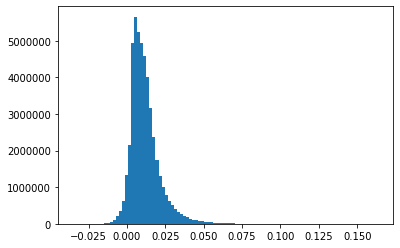

In [78]:
plt.hist(LHF_nsDELQ_test['m4K'].flatten(),bins=100);

In [82]:
# LHF_nsDELQ_test = {}

In [83]:
# for iclim,clim in enumerate(climates):
#     print(clim)
#     LHF_nsDELQ_test[clim] = np.float32(compute_LHF_nsDELQ(test_sets[clim],1e-3))

Save Latent heat fluxes for future use

In [85]:
# data = dict(
#     LHFns=(["samples_train"],LHF_nsDELQ_train),
#     LHFns_cold=(["samples_cold"],LHF_nsDELQ_test['m4K']),
#     LHFns_med=(["samples_med"],LHF_nsDELQ_test['ref']),
#     LHFns_hot=(["samples_hot"],LHF_nsDELQ_test['p4K'])
#     )

# coord = dict(
#     pressure_midlevel=(["pressure"],np.mean(pm,axis=0)),
#     pressure_interfac=(["pressure_interface"],np.mean(pi,axis=0)),
#     samples_train=(["samples_train"],np.arange(0,LHF_nsDELQ_train.shape[0])),
#     samples_cold=(["samples_cold"],np.arange(0,LHF_nsDELQ_test['m4K'].shape[0])),
#     samples_med=(["samples_med"],np.arange(0,LHF_nsDELQ_test['ref'].shape[0])),
#     samples_hot=(["samples_hot"],np.arange(0,LHF_nsDELQ_test['p4K'].shape[0])),
#     )

# da = xr.Dataset(
#     data_vars=data,
#     coords=coord,
#     attrs=dict(description="Climate-invariant latent heat fluxes calculated"+\
#               "using the train set (m4K+p4K) and the test sets on (m4K,ref,p4K)"+\
#               "on June 29th, 2022")
# )

In [86]:
# da.to_netcdf(path_data+'2022_06_29_LHF_nsDELQ.nc')

In [16]:
x.shape

(47177728, 64)

In [17]:
y.shape

(47177728, 60)

In [18]:
xRH.shape

(47177728, 30)

## (Skippable) Sub-sampling

In [34]:
xt_sub = {}; yt_sub = {}; xRHt_sub = {}; xBt_sub = {}; xLHFnst_sub = {};

In [35]:
Nsample = 2000
i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                            size=((Nsample,)),replace=False).astype('int')
# Sub-sample the training set
x_sub = x[i_random,:]; y_sub = y[i_random,:]; 
xRH_sub = xRH[i_random,:]; xB_sub = xB[i_random,:]; 
xLHFns_sub = xLHFns[i_random]
# Sub-sample the test sets
for iclim,clim in enumerate(climates):
    print(clim)
    xt_sub[clim] = xt[clim][i_random,:]
    yt_sub[clim] = yt[clim][i_random,:]
    xRHt_sub[clim] = xRHt[clim][i_random,:]
    xBt_sub[clim] = xBt[clim][i_random,:]
    xLHFnst_sub[clim] = xLHFnst[clim][i_random]

m4K
ref
p4K


In [36]:
x_sub.shape

(2000, 64)

In [37]:
y_sub.shape

(2000, 60)

## Pre-processing utilities

### Calculate vertical derivatives via centered finite difference

In [38]:
PS = x_sub[:,60]

In [39]:
pi = P0*hyai+np.outer(PS,hybi)
pm = P0*hyam+np.outer(PS,hybm)

In [40]:
pi.shape

(2000, 31)

In [15]:
def p_derivative(var,pressure,order=1):
    if order == 1:
        dvar_dp_left = (var[:,[28]]-var[:,[29]])/(pressure[:,[28]]-pressure[:,[29]])
        dvar_dp_mid = (var[:,:28]-var[:,2:30])/(pressure[:,:28]-pressure[:,2:30])
        dvar_dp_right = (var[:,[1]]-var[:,[0]])/(pressure[:,[1]]-pressure[:,[0]])
        output = np.concatenate((dvar_dp_right,dvar_dp_mid,dvar_dp_left),axis=1)
    elif order == 2:
        d2var_dp2_left = (var[:,[29]]-2*var[:,[28]]+var[:,[27]])/((0.5*(pressure[:,[29]]-pressure[:,[27]]))**2)
        d2var_dp2_mid = (var[:,:28]+var[:,2:30]-2*var[:,1:29])/((0.5*(pressure[:,:28]-pressure[:,2:30]))**2)
        d2var_dp2_right = (var[:,[2]]-2*var[:,[1]]+var[:,[0]])/((0.5*(pressure[:,[2]]-pressure[:,[0]]))**2)
        output = np.concatenate((d2var_dp2_right,d2var_dp2_mid,d2var_dp2_left),axis=1)
    
    return output

In [16]:
def p_integral(var,pressure,partial):
    
    g = 9.8
    
    if partial == 'above': INT = cumtrapz(x=pressure,y=var,initial=0)/g
    elif partial == 'below': 
        INT = np.outer(trapz(x=pressure,y=var)/g,np.arange(0,30)**0)-\
        cumtrapz(x=pressure,y=var,initial=0)/g
        
    return INT

### Calculate vertical derivatives via spline interpolation (this script is borrowed from Arthur Grundner (DLR))

In [17]:
def p_der_spline(var,pressure_data,pressure_eval,order,kind='cubic'):
    
    assert var.shape[0] == pressure_eval.shape[0]
    assert var.shape[0] == pressure_data.shape[0]
    
    output = np.zeros(pressure_eval.shape)
    
    for isample in range(var.shape[0]):
        
        f = interpolate.interp1d(pressure_data[isample,:],var[isample,:],kind,axis=0,fill_value="extrapolate")
        
        if order == 1: der = misc.derivative(f, pressure_eval[isample,:], dx=1e-2, n=1, args=(), order=3)
        elif order == 2: der = misc.derivative(f, pressure_eval[isample,:], dx=1e-2, n=2, args=(), order=5)
        output[isample,:] = der
    
    return output

### (Skippable) Test

In [94]:
pm.shape

(2000, 30)

In [95]:
q_test = x_sub[:,:30].values

In [96]:
q1_fd = p_derivative(q_test,pm,1)
q2_fd = p_derivative(q1_fd,pm,1)
q2_fd2 = p_derivative(q_test,pm,2)
q1_sp = p_der_spline(q_test,pm,pm,1)
q2_sp1 = p_der_spline(q_test,pm,pm,2)
q2_sp2 = p_der_spline(q1_sp,pm,pm,1)

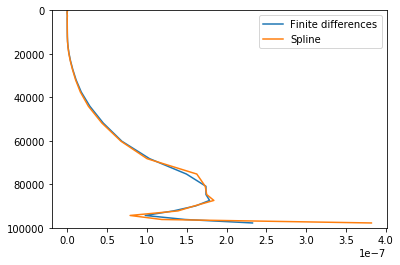

In [98]:
plt.plot(q1_fd.mean(axis=0),pm.mean(axis=0),label='Finite differences')
plt.plot(q1_sp.mean(axis=0),pm.mean(axis=0),label='Spline')
plt.ylim((1e5,0))
plt.legend();

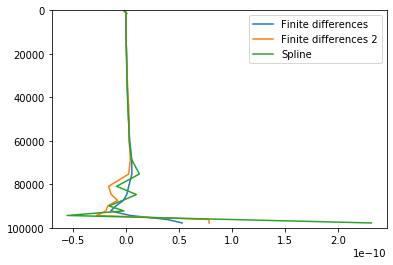

In [100]:
plt.plot(q2_fd.mean(axis=0),pm.mean(axis=0),label='Finite differences')
plt.plot(q2_fd2.mean(axis=0),pm.mean(axis=0),label='Finite differences 2')
plt.plot(q2_sp1.mean(axis=0),pm.mean(axis=0),label='Spline')
# plt.plot(q2_sp2.mean(axis=0),pm.mean(axis=0),label='Spline')
plt.ylim((1e5,0))
plt.legend();

## Create dictionary for sequential feature selection

### Raw dictionary

In [44]:
x_train = {}

In [45]:
x_train['p'] = pm

In [46]:
x_train['q'] = x_sub[:,:30].values

In [47]:
x_train['dq_dp'] = p_der_spline(x_train['q'],x_train['p'],x_train['p'],1)
x_train['dq_dp_FD'] = p_derivative(x_train['q'],x_train['p'],1)

In [48]:
x_train['d2q_dp2'] = p_der_spline(x_train['q'],x_train['p'],x_train['p'],2)
x_train['d2q_dp2_FD'] = p_derivative(x_train['dq_dp'],x_train['p'],1)

In [49]:
x_train['Q_above'] = p_integral(x_train['q'],x_train['p'],'above')
x_train['Q_below'] = p_integral(x_train['q'],x_train['p'],'below')

In [50]:
x_train['T'] = x_sub[:,30:60].values

In [51]:
x_train['dT_dp'] = p_der_spline(x_train['T'],x_train['p'],x_train['p'],1)
x_train['d2T_dp2'] = p_der_spline(x_train['T'],x_train['p'],x_train['p'],2)

In [52]:
x_train['dT_dp_FD'] = p_derivative(x_train['T'],x_train['p'],1)
x_train['d2T_dp2_FD'] = p_derivative(x_train['dT_dp_FD'],x_train['p'],1)

In [53]:
x_train['T_above'] = p_integral(x_train['T'],x_train['p'],'above')
x_train['T_below'] = p_integral(x_train['T'],x_train['p'],'below')

In [54]:
x_train['RH'] = xRH_sub.values

x_train['dRH_dp'] = p_der_spline(x_train['RH'],x_train['p'],x_train['p'],1)
x_train['dRH_dp_FD'] = p_derivative(x_train['RH'],x_train['p'],1)

x_train['d2RH_dp2'] = p_der_spline(x_train['RH'],x_train['p'],x_train['p'],2)
x_train['d2RH_dp2_FD'] = p_derivative(x_train['dRH_dp'],x_train['p'],1)

x_train['RH_above'] = p_integral(x_train['RH'],x_train['p'],'above')
x_train['RH_below'] = p_integral(x_train['RH'],x_train['p'],'below')

x_train['B'] = xB_sub.values

x_train['dB_dp'] = p_der_spline(x_train['B'],x_train['p'],x_train['p'],1)
x_train['d2B_dp2'] = p_der_spline(x_train['B'],x_train['p'],x_train['p'],2)

x_train['dB_dp_FD'] = p_derivative(x_train['B'],x_train['p'],1)
x_train['d2B_dp2_FD'] = p_derivative(x_train['dB_dp_FD'],x_train['p'],1)

x_train['B_above'] = p_integral(x_train['B'],x_train['p'],'above')
x_train['B_below'] = p_integral(x_train['B'],x_train['p'],'below')

In [55]:
x_train['ps'] = x_sub[:,60].values

In [56]:
x_train['S0'] = x_sub[:,61].values

In [57]:
x_train['SHF'] = x_sub[:,62].values

In [58]:
x_train['LHF'] = x_sub[:,63].values

In [59]:
x_train['LHFns'] = xLHFns_sub.values

In [60]:
y_train = {}

In [61]:
y_train['dq_dt'] = y_sub[:,:30].values

In [62]:
y_train['dT_dt'] = y_sub[:,30:60].values

In [63]:
x_test = {}; y_test = {}

In [64]:
for iclim,clim in enumerate(climates):
    x_test[clim] = {}; y_test[clim] = {};
    print('Pressure')
    x_test[clim]['p'] = P0*hyam+np.outer(xt_sub[clim][:,60].values,hybm)
    print('Specific Humidity')
    x_test[clim]['q'] = xt_sub[clim][:,:30].values
    x_test[clim]['dq_dp'] = p_der_spline(x_test[clim]['q'],x_test[clim]['p'],x_test[clim]['p'],1)
    x_test[clim]['dq_dp_FD'] = p_derivative(x_test[clim]['q'],x_test[clim]['p'],1)
    x_test[clim]['d2q_dp2'] = p_der_spline(x_test[clim]['q'],x_test[clim]['p'],x_test[clim]['p'],2)
    x_test[clim]['d2q_dp2_FD'] = p_derivative(x_test[clim]['dq_dp'],x_test[clim]['p'],1)
    x_test[clim]['Q_above'] = p_integral(x_test[clim]['q'],x_test[clim]['p'],'above')
    x_test[clim]['Q_below'] = p_integral(x_test[clim]['q'],x_test[clim]['p'],'below')
    print('Temperature')
    x_test[clim]['T'] = xt_sub[clim][:,30:60].values
    x_test[clim]['dT_dp'] = p_der_spline(x_test[clim]['T'],x_test[clim]['p'],x_test[clim]['p'],1)
    x_test[clim]['dT_dp_FD'] = p_derivative(x_test[clim]['T'],x_test[clim]['p'],1)
    x_test[clim]['d2T_dp2'] = p_der_spline(x_test[clim]['T'],x_test[clim]['p'],x_test[clim]['p'],2)
    x_test[clim]['d2T_dp2_FD'] = p_derivative(x_test[clim]['dT_dp'],x_test[clim]['p'],1)
    x_test[clim]['T_above'] = p_integral(x_test[clim]['T'],x_test[clim]['p'],'above')
    x_test[clim]['T_below'] = p_integral(x_test[clim]['T'],x_test[clim]['p'],'below')
    print('Relative Humidity')
    x_test[clim]['RH'] = xRHt_sub[clim].values
    x_test[clim]['dRH_dp'] = p_der_spline(x_test[clim]['RH'],x_test[clim]['p'],x_test[clim]['p'],1)
    x_test[clim]['dRH_dp_FD'] = p_derivative(x_test[clim]['RH'],x_test[clim]['p'],1)
    x_test[clim]['d2RH_dp2'] = p_der_spline(x_test[clim]['RH'],x_test[clim]['p'],x_test[clim]['p'],2)
    x_test[clim]['d2RH_dp2_FD'] = p_derivative(x_test[clim]['dRH_dp'],x_test[clim]['p'],1)
    x_test[clim]['RH_above'] = p_integral(x_test[clim]['RH'],x_test[clim]['p'],'above')
    x_test[clim]['RH_below'] = p_integral(x_test[clim]['RH'],x_test[clim]['p'],'below')
    print('Buoyancy')
    x_test[clim]['B'] = xBt_sub[clim].values
    x_test[clim]['dB_dp'] = p_der_spline(x_test[clim]['B'],x_test[clim]['p'],x_test[clim]['p'],1)
    x_test[clim]['dB_dp_FD'] = p_derivative(x_test[clim]['B'],x_test[clim]['p'],1)
    x_test[clim]['d2B_dp2'] = p_der_spline(x_test[clim]['B'],x_test[clim]['p'],x_test[clim]['p'],2)
    x_test[clim]['d2B_dp2_FD'] = p_derivative(x_test[clim]['dB_dp'],x_test[clim]['p'],1)
    x_test[clim]['B_above'] = p_integral(x_test[clim]['B'],x_test[clim]['p'],'above')
    x_test[clim]['B_below'] = p_integral(x_test[clim]['B'],x_test[clim]['p'],'below')
    print('Scalars')
    x_test[clim]['ps'] = xt_sub[clim][:,60].values
    x_test[clim]['S0'] = xt_sub[clim][:,61].values
    x_test[clim]['SHF'] = xt_sub[clim][:,62].values
    x_test[clim]['LHF'] = xt_sub[clim][:,63].values
    x_test[clim]['LHFns'] = xLHFnst_sub[clim].values
    print('Outputs')
    y_test[clim]['dq_dt'] = yt_sub[clim][:,:30].values
    y_test[clim]['dT_dt'] = yt_sub[clim][:,30:60].values

Pressure
Specific Humidity
Temperature
Relative Humidity
Buoyancy
Scalars
Outputs
Pressure
Specific Humidity
Temperature
Relative Humidity
Buoyancy
Scalars
Outputs
Pressure
Specific Humidity
Temperature
Relative Humidity
Buoyancy
Scalars
Outputs


### Range normalization

In [65]:
x_test[clim].keys()

dict_keys(['p', 'q', 'dq_dp', 'dq_dp_FD', 'd2q_dp2', 'd2q_dp2_FD', 'Q_above', 'Q_below', 'T', 'dT_dp', 'dT_dp_FD', 'd2T_dp2', 'd2T_dp2_FD', 'T_above', 'T_below', 'RH', 'dRH_dp', 'dRH_dp_FD', 'd2RH_dp2', 'd2RH_dp2_FD', 'RH_above', 'RH_below', 'B', 'dB_dp', 'dB_dp_FD', 'd2B_dp2', 'd2B_dp2_FD', 'B_above', 'B_below', 'ps', 'S0', 'SHF', 'LHF', 'LHFns'])

In [66]:
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp', 'dq_dp_FD', 'd2q_dp2', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp', 'dT_dp_FD', 'd2T_dp2', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp', 'dRH_dp_FD', 'd2RH_dp2', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp', 'dB_dp_FD', 'd2B_dp2', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

In [67]:
Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}

In [68]:
for keys in combin_keys:
    print(keys)
    Norm['mean'][keys] = np.mean(x_train[keys].flatten())
    Norm['min'][keys] = np.min(x_train[keys].flatten())
    Norm['max'][keys] = np.max(x_train[keys].flatten())
    Norm['std'][keys] = np.std(x_train[keys].flatten())

ps
S0
SHF
LHF
LHFns
p
q
dq_dp
dq_dp_FD
d2q_dp2
d2q_dp2_FD
Q_above
Q_below
T
dT_dp
dT_dp_FD
d2T_dp2
d2T_dp2_FD
T_above
T_below
RH
dRH_dp
dRH_dp_FD
d2RH_dp2
d2RH_dp2_FD
RH_above
RH_below
B
dB_dp
dB_dp_FD
d2B_dp2
d2B_dp2_FD
B_above
B_below


In [69]:
Norm

{'mean': {'ps': 98506.9694296875,
  'S0': 353.51822138750555,
  'SHF': 12.26870066269883,
  'LHF': 62.39293659684062,
  'LHFns': 0.011613268,
  'p': 41556.831532489065,
  'q': 0.0015817483519248625,
  'dq_dp': 6.171153493189577e-08,
  'dq_dp_FD': 5.793609897743146e-08,
  'd2q_dp2': 9.395195180684977e-12,
  'd2q_dp2_FD': 8.108477968963203e-12,
  'Q_above': 3.000482693602204,
  'Q_below': 11.21655866847827,
  'T': 236.8350613471985,
  'dT_dp': -0.0005163961541929751,
  'dT_dp_FD': -0.0007878710784562073,
  'd2T_dp2': -2.451015365482571e-06,
  'd2T_dp2_FD': 6.971516821981371e-07,
  'T_above': 973177.7144317421,
  'T_below': 1433801.3441150472,
  'RH': 0.45953476,
  'dRH_dp': 1.0692070055408654e-05,
  'dRH_dp_FD': 1.0052317577942869e-05,
  'd2RH_dp2': -1.0828598420625382e-10,
  'd2RH_dp2_FD': -1.7742457019760537e-09,
  'RH_above': 1862.6304411050767,
  'RH_below': 3593.4749572612272,
  'B': -1.6857717,
  'dB_dp': -0.00014385335418033382,
  'dB_dp_FD': -0.00013482665756205475,
  'd2B_dp2': 

In [70]:
x_train_range = {}
x_test_range = {}

In [71]:
for key in scalar_keys:
    x_train[key] = np.outer(x_train[key],np.ones((30,)))

In [72]:
for iclim,clim in enumerate(climates):
    for key in scalar_keys:
        x_test[clim][key] = np.outer(x_test[clim][key],np.ones((30,)))

In [73]:
for key in combin_keys: x_train_range[key] = (x_train[key].flatten()-Norm['min'][key])/(Norm['max'][key]-Norm['min'][key])

In [74]:
for iclim,clim in enumerate(climates):
    x_test_range[clim] = {}
    for key in combin_keys:
        x_test_range[clim][key] = (x_test[clim][key].flatten()-Norm['min'][key])/(Norm['max'][key]-Norm['min'][key])

/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


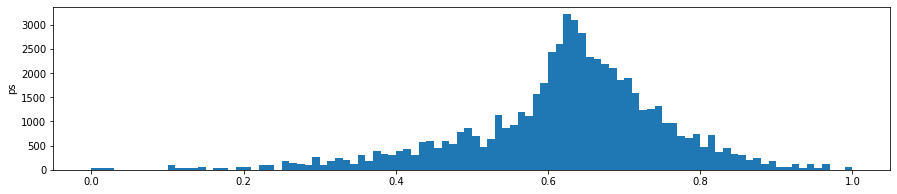

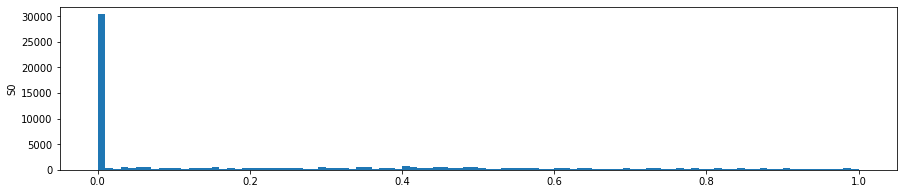

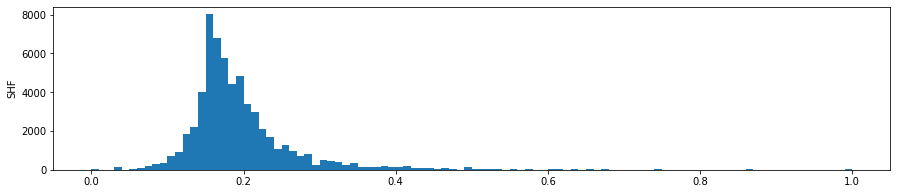

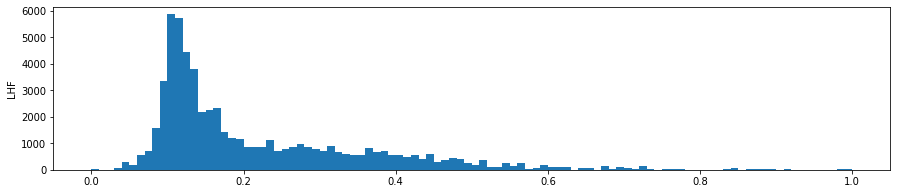

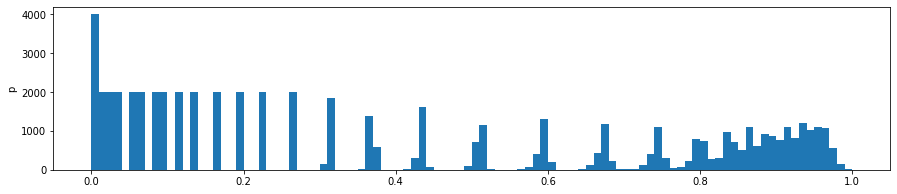

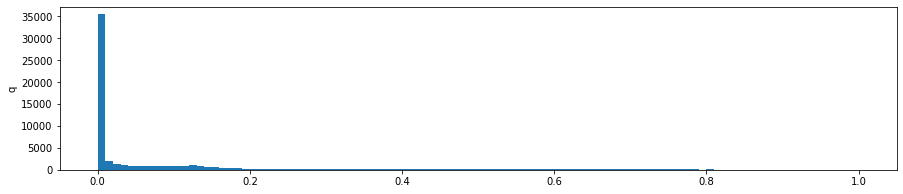

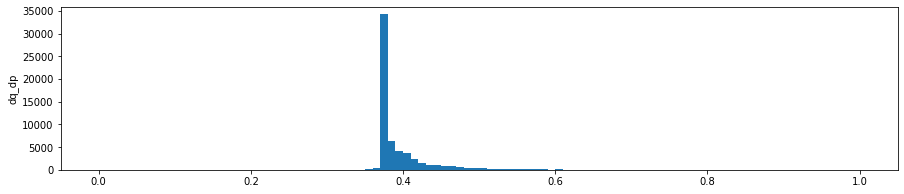

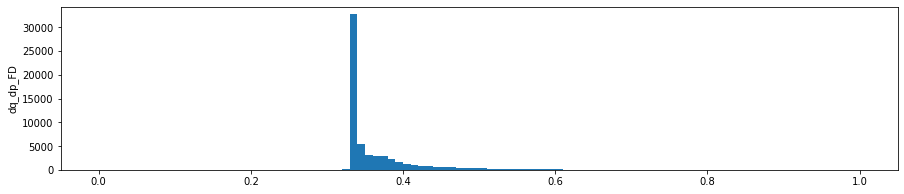

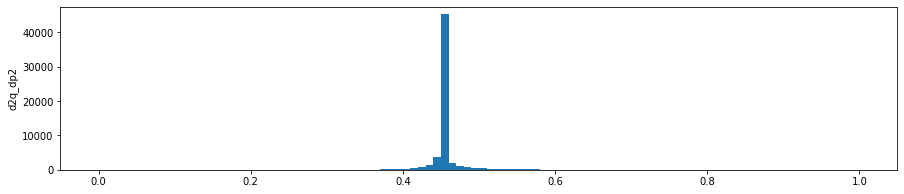

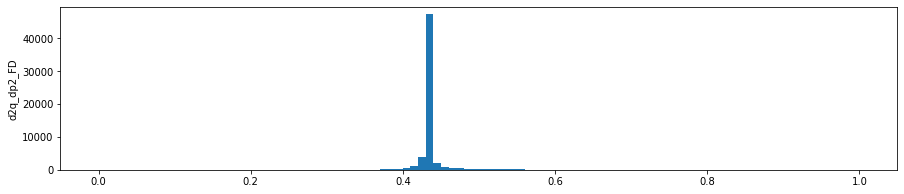

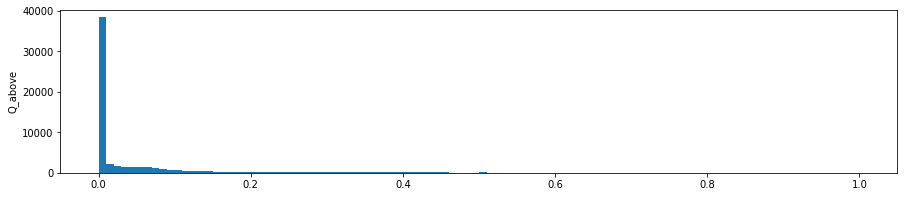

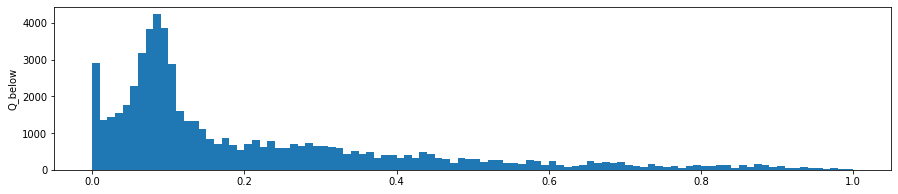

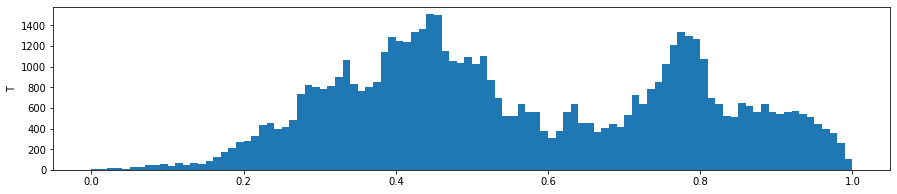

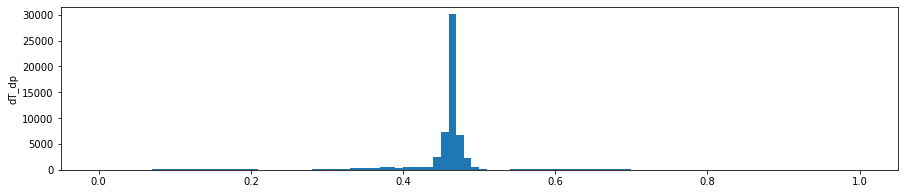

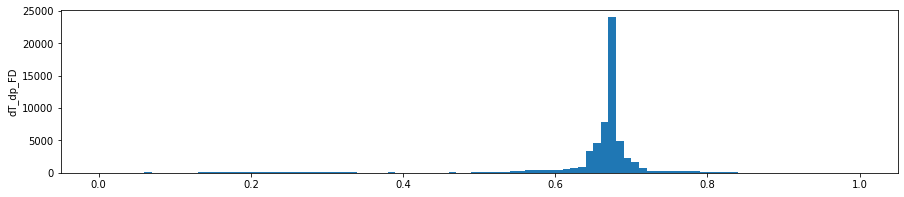

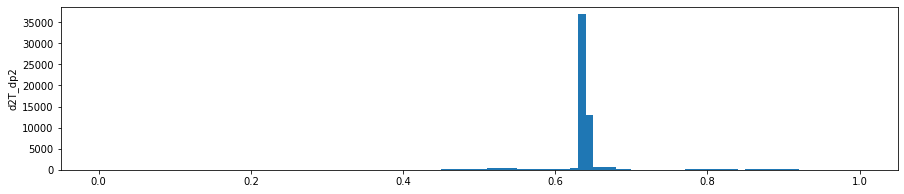

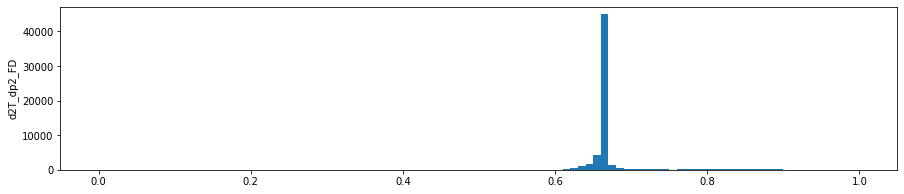

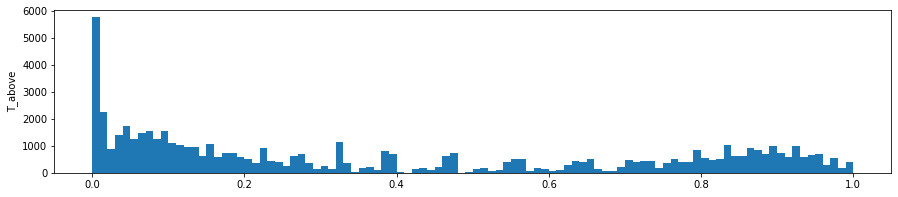

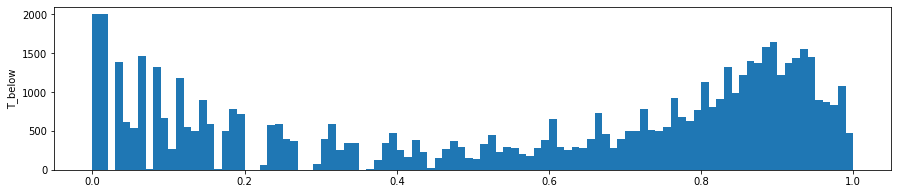

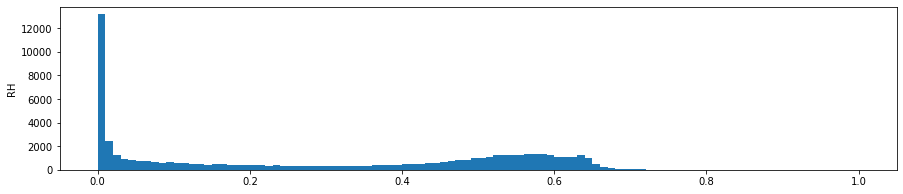

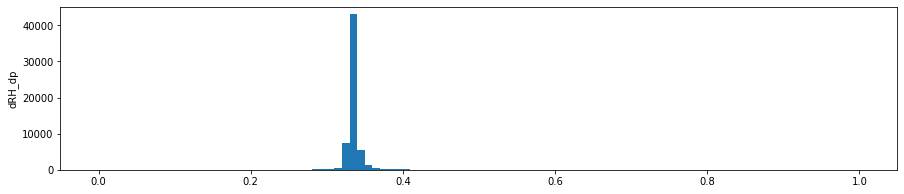

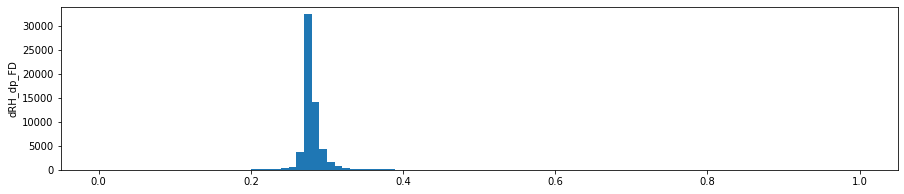

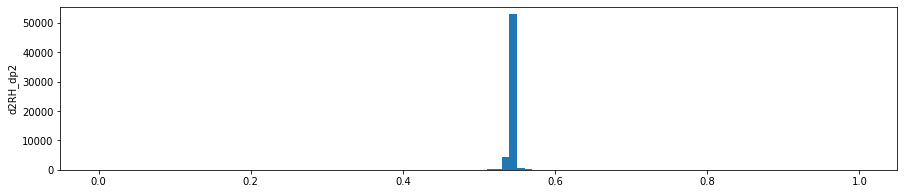

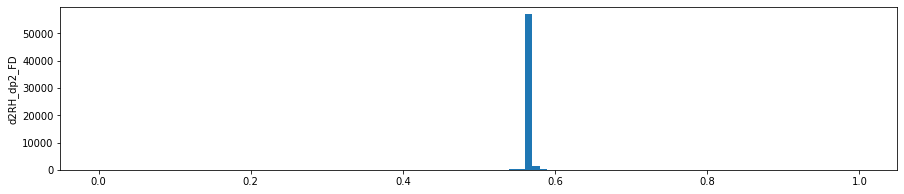

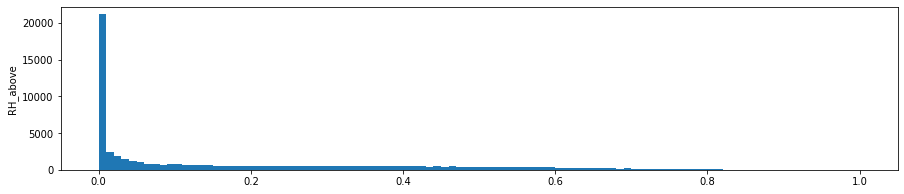

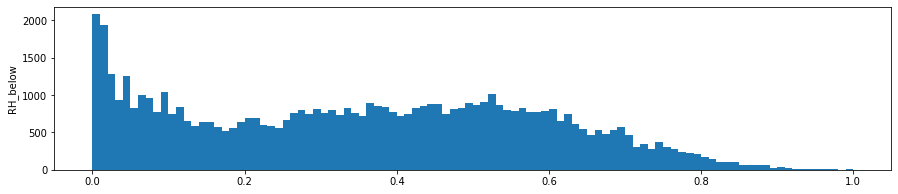

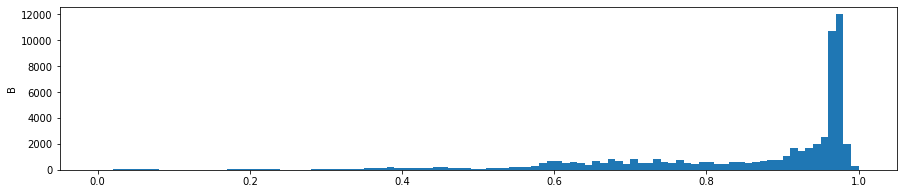

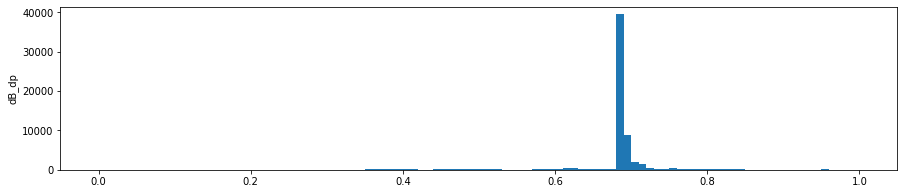

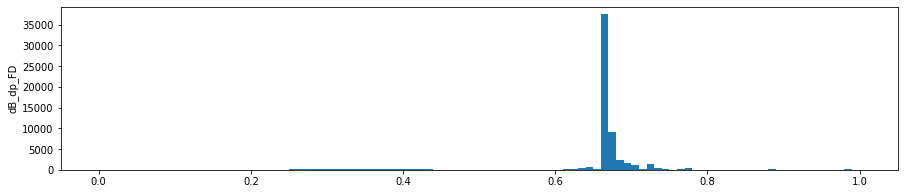

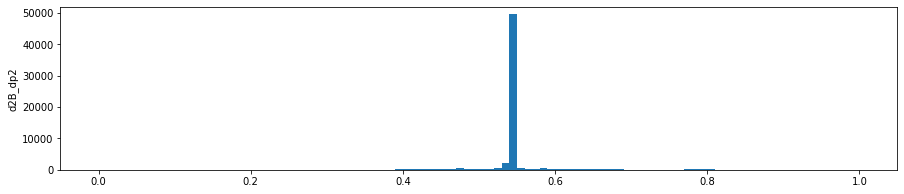

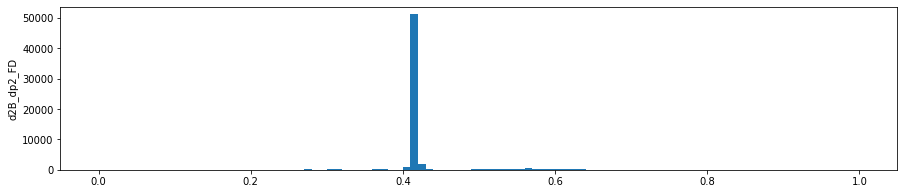

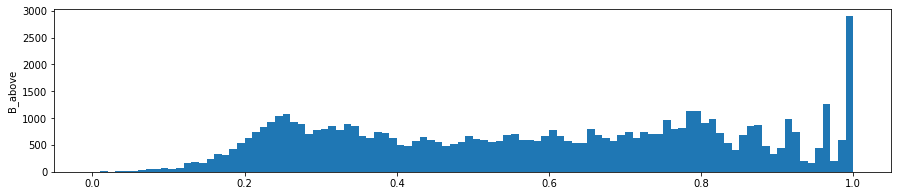

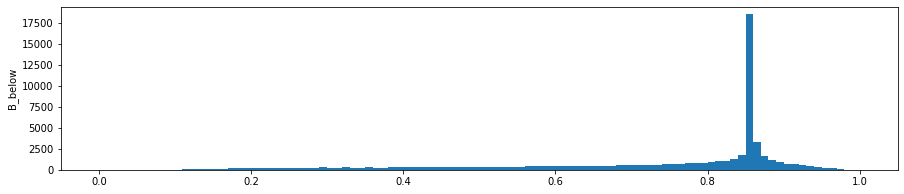

In [185]:
for key in combin_keys:
    fig = plt.figure(figsize=(15,3))
    plt.ylabel(key)
    plt.hist(x_train_range[key],bins=100);

## Pre-processing for regression purposes

In [75]:
x_train_range.keys()

dict_keys(['ps', 'S0', 'SHF', 'LHF', 'LHFns', 'p', 'q', 'dq_dp', 'dq_dp_FD', 'd2q_dp2', 'd2q_dp2_FD', 'Q_above', 'Q_below', 'T', 'dT_dp', 'dT_dp_FD', 'd2T_dp2', 'd2T_dp2_FD', 'T_above', 'T_below', 'RH', 'dRH_dp', 'dRH_dp_FD', 'd2RH_dp2', 'd2RH_dp2_FD', 'RH_above', 'RH_below', 'B', 'dB_dp', 'dB_dp_FD', 'd2B_dp2', 'd2B_dp2_FD', 'B_above', 'B_below'])

In [76]:
x_test_range.keys()

dict_keys(['m4K', 'ref', 'p4K'])

In [101]:
local_keys = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
local_CI_keys = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
local_BF_keys = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']

In [102]:
X_test_local = {}; X_test_localCI = {}; X_test_localBF = {};

In [103]:
X_train_local = np.zeros((x_train_range['p'].shape[0],len(local_keys)))
X_train_localCI = np.zeros((x_train_range['p'].shape[0],len(local_CI_keys)))
X_train_localBF = np.zeros((x_train_range['p'].shape[0],len(local_BF_keys)))
for iclim,clim in enumerate(climates):
    X_test_local[clim] = np.zeros((x_test_range[clim]['p'].shape[0],len(local_keys)))
    X_test_localCI[clim] = np.zeros((x_test_range[clim]['p'].shape[0],len(local_CI_keys)))
    X_test_localBF[clim] = np.zeros((x_test_range[clim]['p'].shape[0],len(local_BF_keys)))

In [104]:
for ikey,key in enumerate(local_keys):
    print(key)
    X_train_local[:,ikey] = x_train_range[key]
    for iclim,clim in enumerate(climates):
        X_test_local[clim][:,ikey] = x_test_range[clim][key]

ps
S0
SHF
LHF
LHFns
p
q
dq_dp_FD
d2q_dp2_FD
T
dT_dp_FD
d2T_dp2_FD
RH
dRH_dp_FD
d2RH_dp2_FD
B
dB_dp_FD
d2B_dp2_FD


In [105]:
for ikey,key in enumerate(local_CI_keys):
    print(key)
    X_train_localCI[:,ikey] = x_train_range[key]
    for iclim,clim in enumerate(climates):
        X_test_localCI[clim][:,ikey] = x_test_range[clim][key]

ps
S0
SHF
LHFns
p
RH
dRH_dp_FD
d2RH_dp2_FD
B
dB_dp_FD
d2B_dp2_FD


In [106]:
for ikey,key in enumerate(local_BF_keys):
    print(key)
    X_train_localBF[:,ikey] = x_train_range[key]
    for iclim,clim in enumerate(climates):
        X_test_localBF[clim][:,ikey] = x_test_range[clim][key]

ps
S0
SHF
LHF
p
q
dq_dp_FD
d2q_dp2_FD
T
dT_dp_FD
d2T_dp2_FD


In [107]:
dtdt_test = {}; dqdt_test = {}; dTdt_test = {}; dQdt_test = {};

In [108]:
dtdt_train = y_train['dT_dt'].flatten()
dqdt_train = y_train['dq_dt'].flatten()
dTdt_train = (y_train['dT_dt'] * scale_dict['TPHYSTND']).flatten()
dQdt_train = (y_train['dq_dt'] * scale_dict['PHQ']).flatten()
for iclim,clim in enumerate(climates):
    dtdt_test[clim] = y_test[clim]['dT_dt'].flatten()
    dqdt_test[clim] = y_test[clim]['dq_dt'].flatten()
    dTdt_test[clim] = (y_test[clim]['dT_dt'] * scale_dict['TPHYSTND']).flatten()
    dQdt_test[clim] = (y_test[clim]['dq_dt'] * scale_dict['PHQ']).flatten()

# Pol fit + Seq Feature Selection using local variables

In [85]:
save_folder = path_data+'Polynomial_Fits/'

## Linear

In [225]:
cv = 2
min_features_to_select = 1
max_features_to_select = 8

In [226]:
dict_combined = {}

In [227]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train_local, dQdt_train)
    selected_features = np.array(local_keys)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train_local)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test_local[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['dq_dp']
{'dq_dp': 54.31796579730877, 'LR_Bias': -21.815431515921336, 'mse_train': 915.5020223796404, 'mse_test': {'m4K': 917.6434408519103, 'ref': 1333.006012529806, 'p4K': 2094.4517594224794}} 

Features selected by forward sequential selection: ['dq_dp', 'RH']
{'dq_dp': 84.30882805272164, 'RH': -13.59040121107867, 'LR_Bias': -29.741845079028185, 'mse_train': 905.9318436860976, 'mse_test': {'m4K': 909.5442409866495, 'ref': 1321.6277299682847, 'p4K': 2076.2631105116166}} 

Features selected by forward sequential selection: ['p', 'dq_dp', 'RH']
{'p': 9.020586694117954, 'dq_dp': 61.61555567717078, 'RH': -21.5830060529261, 'LR_Bias': -22.078063250389572, 'mse_train': 902.3453127310415, 'mse_test': {'m4K': 906.9919373190714, 'ref': 1316.0295835452239, 'p4K': 2068.6751119813875}} 

Features selected by forward sequential selection: ['p', 'dq_dp', 'T', 'RH']
{'p': 32.65287241912399, 'dq_dp': 87.75794655013664, 'T': -36.48775457132747, 'RH'

In [228]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train_localBF, dQdt_train)
    selected_features = np.array(local_BF_keys)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train_localBF)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test_localBF[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['dq_dp']
{'dq_dp': 54.31796579730877, 'LR_Bias': -21.815431515921336, 'mse_train': 915.5020223796404, 'mse_test': {'m4K': 917.6434408519103, 'ref': 1333.006012529806, 'p4K': 2094.4517594224794}} 

Features selected by forward sequential selection: ['q', 'dq_dp']
{'q': -18.66072354759615, 'dq_dp': 106.63755680521359, 'LR_Bias': -40.9017067730624, 'mse_train': 909.7233442183652, 'mse_test': {'m4K': 911.1066613596719, 'ref': 1325.6726198350236, 'p4K': 2087.3041071966877}} 

Features selected by forward sequential selection: ['LHF', 'q', 'dq_dp']
{'LHF': 16.2170616390927, 'q': -20.84108524248498, 'dq_dp': 104.34386079467971, 'LR_Bias': -43.31906465618594, 'mse_train': 904.3813556943984, 'mse_test': {'m4K': 905.7249196977888, 'ref': 1317.3370072006007, 'p4K': 2077.7366165920325}} 

Features selected by forward sequential selection: ['ps', 'LHF', 'q', 'dq_dp']
{'ps': 7.014023942412273, 'LHF': 15.390675933657732, 'q': -20.788924230650697, 'd

In [229]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train_localCI, dQdt_train)
    selected_features = np.array(local_CI_keys)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train_localCI)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test_localCI[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['LHF']
{'LHF': 16.151387648175398, 'LR_Bias': -3.765774885890938, 'mse_train': 915.5845553222427, 'mse_test': {'m4K': 916.3130351779945, 'ref': 1329.0774674041536, 'p4K': 2096.1171914320435}} 

Features selected by forward sequential selection: ['LHF', 'RH']
{'LHF': 15.178848765422211, 'RH': -7.093490634364137, 'LR_Bias': -1.4784876916915866, 'mse_train': 912.5328637155376, 'mse_test': {'m4K': 913.5436235213356, 'ref': 1324.9124365591929, 'p4K': 2090.546985195503}} 

Features selected by forward sequential selection: ['LHF', 'p', 'RH']
{'LHF': 13.253267655248292, 'p': 12.84866803158637, 'RH': -20.784101609550255, 'LR_Bias': -2.298695038517027, 'mse_train': 903.6532258661864, 'mse_test': {'m4K': 906.9317573021102, 'ref': 1313.9412180225322, 'p4K': 2072.9759804730643}} 

Features selected by forward sequential selection: ['LHF', 'p', 'RH', 'dRH_dp']
{'LHF': 13.244400359564144, 'p': 13.13086369164865, 'RH': -21.151741883562412, 'dRH_dp':

## Cubic

In [111]:
cv = 2
deg = 3
min_features_to_select = 1
max_features_to_select = 4

In [112]:
poly = PolynomialFeatures(degree=deg)
X_train_local3 = poly.fit_transform(X_train_local)    
features_local = poly.get_feature_names(np.array(local_keys)) # Update the feature names
X_train_local3BF = poly.fit_transform(X_train_localBF)    
features_localBF = poly.get_feature_names(np.array(local_BF_keys)) # Update the feature names
X_train_local3CI = poly.fit_transform(X_train_localCI)    
features_localCI = poly.get_feature_names(np.array(local_CI_keys)) # Update the feature names

X_test_local3 = {}; X_test_local3BF = {}; X_test_local3CI = {};
for iclim,clim in enumerate(climates):
    print(clim)
    X_test_local3[clim] = poly.fit_transform(X_test_local[clim])
    X_test_local3BF[clim] = poly.fit_transform(X_test_localBF[clim])
    X_test_local3CI[clim] = poly.fit_transform(X_test_localCI[clim])

m4K
ref
p4K


In [113]:
dict_combined = {}

In [114]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train_local3, dQdt_train)
    selected_features = np.array(features_local)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train_local3)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test_local3[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['LHF dq_dp_FD^2']
{'LHF dq_dp_FD^2': 97.42728569252367, 'LR_Bias': -5.029129909794673, 'mse_train': 931.787599115249, 'mse_test': {'m4K': 891.4670552804947, 'ref': 1382.3177605079554, 'p4K': 2230.124584607275}} 

Features selected by forward sequential selection: ['LHF dq_dp_FD^2', 'LHFns RH^2']
{'LHF dq_dp_FD^2': 122.06525521617606, 'LHFns RH^2': -98.66022078451522, 'LR_Bias': -2.7829279770644537, 'mse_train': 915.9978986146326, 'mse_test': {'m4K': 873.8953244641058, 'ref': 1362.0253929983844, 'p4K': 2180.7027607978516}} 

Features selected by forward sequential selection: ['SHF RH dB_dp_FD', 'LHF dq_dp_FD^2', 'LHFns RH^2']
{'SHF RH dB_dp_FD': 259.38744961163496, 'LHF dq_dp_FD^2': 117.99426708629943, 'LHFns RH^2': -352.54162905761973, 'LR_Bias': -5.699904368956053, 'mse_train': 896.7284346583801, 'mse_test': {'m4K': 852.4472362178398, 'ref': 1337.0205493872259, 'p4K': 2122.1336265116224}} 



In [115]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train_local3BF, dQdt_train)
    selected_features = np.array(features_localBF)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train_local3BF)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test_local3BF[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['LHF dq_dp_FD^2']
{'LHF dq_dp_FD^2': 97.42728569252367, 'LR_Bias': -5.029129909794673, 'mse_train': 931.787599115249, 'mse_test': {'m4K': 891.4670552804947, 'ref': 1382.3177605079554, 'p4K': 2230.124584607275}} 

Features selected by forward sequential selection: ['LHF dq_dp_FD', 'LHF dq_dp_FD^2']
{'LHF dq_dp_FD': -119.29035287713842, 'LHF dq_dp_FD^2': 307.7413970889748, 'LR_Bias': -3.25785445779077, 'mse_train': 927.2309421542803, 'mse_test': {'m4K': 885.2054719619309, 'ref': 1378.730790376444, 'p4K': 2233.1830465730186}} 

Features selected by forward sequential selection: ['LHF dq_dp_FD', 'LHF dq_dp_FD^2', 'q dq_dp_FD^2']
{'LHF dq_dp_FD': -267.4184571058413, 'LHF dq_dp_FD^2': 629.6701430926897, 'q dq_dp_FD^2': -76.41872426859716, 'LR_Bias': -1.9681826745054758, 'mse_train': 916.4709447468204, 'mse_test': {'m4K': 871.9109359290893, 'ref': 1361.5358297659425, 'p4K': 2216.6914162603794}} 



In [116]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train_local3CI, dQdt_train)
    selected_features = np.array(features_localCI)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train_local3CI)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test_local3CI[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['RH^3']
{'RH^3': -36.680291285598685, 'LR_Bias': 2.9265753846175198, 'mse_train': 934.13230294585, 'mse_test': {'m4K': 893.5328834930621, 'ref': 1392.0779608497667, 'p4K': 2230.2117418887824}} 

Features selected by forward sequential selection: ['RH^3', 'RH^2 dB_dp_FD']
{'RH^3': -358.3441086647136, 'RH^2 dB_dp_FD': 302.51400390613077, 'LR_Bias': -1.216029662847381, 'mse_train': 906.0849030204338, 'mse_test': {'m4K': 878.2559454605281, 'ref': 1373.0305246823614, 'p4K': 2186.5676985780556}} 

Features selected by forward sequential selection: ['RH dB_dp_FD', 'RH^3', 'RH^2 dB_dp_FD']
{'RH dB_dp_FD': -136.13888387861172, 'RH^3': -672.3330753591794, 'RH^2 dB_dp_FD': 798.5292908719467, 'LR_Bias': 1.5998562097598514, 'mse_train': 899.0707220189219, 'mse_test': {'m4K': 877.3912933559384, 'ref': 1366.546272526709, 'p4K': 2173.072827071801}} 



# (Legacy) Polynomial fit + Sequential Feature Selection using standard variables

In [78]:
save_folder = path_data+'Polynomial_Fits/'

## Linear

In [64]:
cv = 2
min_features_to_select = 1
max_features_to_select = 15

### dQ/dt

In [65]:
dict_combined = {}

In [72]:
scale_dict

{'PHQ': array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
        3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
        4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
        8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
        1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
        1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
        6.7863763e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
        4.4820160e+08, 3.7970438e+08], dtype=float32),
 'PHCLDLIQ': array([7.0811688e+07, 1.3074196e+08, 2.1416970e+08, 3.0895507e+08,
        3.8762451e+08, 4.4520458e+08, 4.4321341e+08, 3.6317286e+08,
        4.2725360e+08, 5.0264173e+08, 5.9133267e+08, 6.9567149e+08,
        8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
        1.5677202e+09, 1.8443410e+09, 2.1697720e+09, 2.1706406e+09,
        1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
        6.7863763e+08, 6.2842387e+08, 5.73

In [82]:
ypred.reshape((Nsample,30)).shape

(2000, 30)

In [86]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train, dQdt_train)
    selected_features = np.array(key_array)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['dq_dp']
{'dq_dp': 51.1697775380529, 'LR_Bias': -22.9097819399296, 'mse_train': 887.3107453459537, 'mse_test': {'m4K': 934.5928269541669, 'ref': 1351.1910737374724, 'p4K': 2244.9407626993966}} 

Features selected by forward sequential selection: ['q', 'dq_dp']
{'q': -24.789755948503128, 'dq_dp': 122.71436971519093, 'LR_Bias': -52.568994582001416, 'mse_train': 879.2772825174045, 'mse_test': {'m4K': 922.5127764991018, 'ref': 1340.943480967136, 'p4K': 2230.9558069077448}} 

Features selected by forward sequential selection: ['LHF', 'q', 'dq_dp']
{'LHF': 14.940140906049745, 'q': -26.515995287198432, 'dq_dp': 119.5831311468588, 'LR_Bias': -54.131295316197416, 'mse_train': 874.5994339397528, 'mse_test': {'m4K': 917.9192327696801, 'ref': 1332.486503812247, 'p4K': 2222.0462024363014}} 

Features selected by forward sequential selection: ['LHF', 'q', 'dq_dp', 'Q_below']
{'LHF': 25.526262492781317, 'q': -33.00753012787754, 'dq_dp': 126.74158720

In [88]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_25_deg1_dQdt_cv'+str(cv)
pickle.dump(dict_combined, open(save_path,'wb'))

### dT/dt

In [89]:
dict_combined = {}

In [90]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train, dTdt_train)
    selected_features = np.array(key_array)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train)

    lin_reg.fit(X_transformed, dTdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dTdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test[clim]))
        mse_test[clim] = mean_squared_error(dTdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['S0']
{'S0': 6.7662033128911485, 'LR_Bias': -1.9868834075312658, 'mse_train': 482.83168170944674, 'mse_test': {'m4K': 499.6809088499507, 'ref': 623.0146819089481, 'p4K': 1003.4952536181283}} 

Features selected by forward sequential selection: ['S0', 'q']
{'S0': 6.5468260200201005, 'q': 10.749399376995019, 'LR_Bias': -2.940840531042038, 'mse_train': 478.96542318233685, 'mse_test': {'m4K': 494.7191883128249, 'ref': 618.2691617336403, 'p4K': 994.9646024147983}} 

Features selected by forward sequential selection: ['S0', 'q', 'Q_below']
{'S0': 6.131972680939934, 'q': 12.313734349433343, 'Q_below': 7.7640187942678, 'LR_Bias': -4.736407940063636, 'mse_train': 476.12022225754134, 'mse_test': {'m4K': 492.2367745773472, 'ref': 615.4952277923729, 'p4K': 990.0727082980433}} 

Features selected by forward sequential selection: ['S0', 'q', 'dq_dp', 'Q_below']
{'S0': 6.12961071287542, 'q': 23.439068746619316, 'dq_dp': -52.09817075227558, 'Q_below'

In [92]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_25_deg1_dTdt_cv'+str(cv)
pickle.dump(dict_combined, open(save_path,'wb'))

## Quadratic

In [93]:
cv = 2
deg = 2
min_features_to_select = 1
max_features_to_select = 10

In [97]:
poly = PolynomialFeatures(degree=deg)
X_train2 = poly.fit_transform(X_train)

if deg == 2:
    assert X_train2.shape[1] == 1 + len(key_array)/2*(len(key_array)+3)
    
print(X_train2.shape[1])
    
new_features = poly.get_feature_names(np.array(key_array)) # Update the feature names

X_test2 = {}
for iclim,clim in enumerate(climates):
    X_test2[clim] = poly.fit_transform(X_test[clim])

136


In [98]:
new_features

['1',
 'ps',
 'S0',
 'SHF',
 'LHF',
 'p',
 'q',
 'dq_dp',
 'd2q_dp2',
 'Q_above',
 'Q_below',
 'T',
 'dT_dp',
 'd2T_dp2',
 'T_above',
 'T_below',
 'ps^2',
 'ps S0',
 'ps SHF',
 'ps LHF',
 'ps p',
 'ps q',
 'ps dq_dp',
 'ps d2q_dp2',
 'ps Q_above',
 'ps Q_below',
 'ps T',
 'ps dT_dp',
 'ps d2T_dp2',
 'ps T_above',
 'ps T_below',
 'S0^2',
 'S0 SHF',
 'S0 LHF',
 'S0 p',
 'S0 q',
 'S0 dq_dp',
 'S0 d2q_dp2',
 'S0 Q_above',
 'S0 Q_below',
 'S0 T',
 'S0 dT_dp',
 'S0 d2T_dp2',
 'S0 T_above',
 'S0 T_below',
 'SHF^2',
 'SHF LHF',
 'SHF p',
 'SHF q',
 'SHF dq_dp',
 'SHF d2q_dp2',
 'SHF Q_above',
 'SHF Q_below',
 'SHF T',
 'SHF dT_dp',
 'SHF d2T_dp2',
 'SHF T_above',
 'SHF T_below',
 'LHF^2',
 'LHF p',
 'LHF q',
 'LHF dq_dp',
 'LHF d2q_dp2',
 'LHF Q_above',
 'LHF Q_below',
 'LHF T',
 'LHF dT_dp',
 'LHF d2T_dp2',
 'LHF T_above',
 'LHF T_below',
 'p^2',
 'p q',
 'p dq_dp',
 'p d2q_dp2',
 'p Q_above',
 'p Q_below',
 'p T',
 'p dT_dp',
 'p d2T_dp2',
 'p T_above',
 'p T_below',
 'q^2',
 'q dq_dp',
 'q 

### dQ/dt

In [100]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train2, dQdt_train)
    selected_features = np.array(new_features)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train2)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test2[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['LHF T_above']
{'LHF T_above': 29.099051403622717, 'LR_Bias': -2.395120906196939, 'mse_train': 883.8817435590736, 'mse_test': {'m4K': 932.8422075788453, 'ref': 1342.293643780496, 'p4K': 2228.8606356826685}} 

Features selected by forward sequential selection: ['LHF T_above', 'q T_below']
{'LHF T_above': 57.350336164626796, 'q T_below': -271.5190648325588, 'LR_Bias': -1.834190966018216, 'mse_train': 857.5105291585694, 'mse_test': {'m4K': 905.2121558320881, 'ref': 1299.6349510874213, 'p4K': 2144.5578654610476}} 

Features selected by forward sequential selection: ['LHF T_above', 'q T_below', 'dq_dp^2']
{'LHF T_above': 37.267426895317875, 'q T_below': -365.2797260749193, 'dq_dp^2': 101.58777004230268, 'LR_Bias': -19.770472375809238, 'mse_train': 843.8594861919448, 'mse_test': {'m4K': 889.3136798657233, 'ref': 1278.0243779838522, 'p4K': 2118.070647978441}} 

Features selected by forward sequential selection: ['SHF q', 'LHF T_above', 'q T_

In [101]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_25_deg2_dQdt_cv'+str(cv)
pickle.dump(dict_combined, open(save_path,'wb'))

### dT/dt

In [102]:
dict_combined = {}

In [103]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train2, dTdt_train)
    selected_features = np.array(new_features)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train2)

    lin_reg.fit(X_transformed, dTdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dTdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test2[clim]))
        mse_test[clim] = mean_squared_error(dTdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['q T_below']
{'q T_below': 193.27492748994314, 'LR_Bias': -2.37328018470803, 'mse_train': 468.9838288797484, 'mse_test': {'m4K': 484.01153805752074, 'ref': 605.4636491249532, 'p4K': 966.9445908405955}} 

Features selected by forward sequential selection: ['q T_below', 'Q_below T_above']
{'q T_below': 377.74019263848413, 'Q_below T_above': -61.86789690889674, 'LR_Bias': -0.693918496105987, 'mse_train': 461.5591301624604, 'mse_test': {'m4K': 475.6508145655432, 'ref': 591.6400084801526, 'p4K': 936.9463915963638}} 

Features selected by forward sequential selection: ['p Q_below', 'q T_below', 'Q_below T_above']
{'p Q_below': 1564.2706149288883, 'q T_below': 983.3368451960257, 'Q_below T_above': -1850.6894108209856, 'LR_Bias': -1.845486431102803, 'mse_train': 426.26159528413876, 'mse_test': {'m4K': 443.27710085058123, 'ref': 566.4300245265342, 'p4K': 983.7915871336077}} 

Features selected by forward sequential selection: ['S0 SHF', 'p Q_b

In [104]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_25_deg2_dTdt_cv'+str(cv)
pickle.dump(dict_combined, open(save_path,'wb'))

## Cubic

In [109]:
cv = 2
deg = 3
min_features_to_select = 1
max_features_to_select = 10

In [110]:
poly = PolynomialFeatures(degree=deg)
X_train3 = poly.fit_transform(X_train)

print(X_train3.shape[1])
    
new_features = poly.get_feature_names(np.array(key_array)) # Update the feature names

X_test3 = {}
for iclim,clim in enumerate(climates):
    X_test3[clim] = poly.fit_transform(X_test[clim])

NameError: name 'X_train' is not defined

### dQ/dt

In [106]:
dict_combined = {}

In [108]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train3, dQdt_train)
    selected_features = np.array(new_features)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train3)

    lin_reg.fit(X_transformed, dQdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dQdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test3[clim]))
        mse_test[clim] = mean_squared_error(dQdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['Q_above T_below^2']
{'Q_above T_below^2': -1791.4721896058443, 'LR_Bias': 2.0102994328707346, 'mse_train': 865.0616831791059, 'mse_test': {'m4K': 910.7564965428066, 'ref': 1337.8050186676069, 'p4K': 2229.460643927211}} 

Features selected by forward sequential selection: ['Q_above T_below^2', 'Q_below T_above^2']
{'Q_above T_below^2': -4997.229259468132, 'Q_below T_above^2': 214.38583148810298, 'LR_Bias': -1.131892336235134, 'mse_train': 821.6022721229303, 'mse_test': {'m4K': 871.1640295309111, 'ref': 1342.2932096248574, 'p4K': 2441.043992916318}} 

Features selected by forward sequential selection: ['LHF dq_dp^2', 'Q_above T_below^2', 'Q_below T_above^2']
{'LHF dq_dp^2': 86.19042110503568, 'Q_above T_below^2': -4597.423280004793, 'Q_below T_above^2': 169.6053409464212, 'LR_Bias': -3.932635837577067, 'mse_train': 814.0248653563366, 'mse_test': {'m4K': 862.8068604916828, 'ref': 1315.4579766169834, 'p4K': 2363.3755875883676}} 

Feature

In [109]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_25_deg3_dQdt_cv'+str(cv)
pickle.dump(dict_combined, open(save_path,'wb'))

### dT/dt

In [110]:
dict_combined = {}

In [111]:
lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select):   
    
    sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
    sfs.fit(X_train3, dTdt_train)
    selected_features = np.array(new_features)[sfs.get_support()].tolist()
    print(
        "Features selected by forward sequential selection: "
        f"{selected_features}"
    )

    X_transformed = sfs.transform(X_train3)

    lin_reg.fit(X_transformed, dTdt_train)
    ypred = lin_reg.predict(X_transformed)
    mse_train = mean_squared_error(dTdt_train, ypred)
    mse_test = {}; ypred_test = {};
    for iclim,clim in enumerate(climates):
        ypred_test[clim] = lin_reg.predict(sfs.transform(X_test3[clim]))
        mse_test[clim] = mean_squared_error(dTdt_test[clim], ypred_test[clim])
    
    # Output function
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['LR_Bias'] = lin_reg.intercept_
    dict_exp['mse_train'] = mse_train
    dict_exp['mse_test'] = mse_test
    print(dict_exp,'\n')
    
    dict_combined['Number of variables %d'%no_features] = dict_exp

Features selected by forward sequential selection: ['q Q_below T_below']
{'q Q_below T_below': 582.788865130556, 'LR_Bias': -2.1632561171584133, 'mse_train': 450.2165917423246, 'mse_test': {'m4K': 466.1875461297199, 'ref': 628.1280281403509, 'p4K': 1177.7177633497904}} 

Features selected by forward sequential selection: ['q Q_below T_below', 'dq_dp Q_below T_above']
{'q Q_below T_below': 1428.7252088800476, 'dq_dp Q_below T_above': -252.23765547770824, 'LR_Bias': 2.2831024398709325, 'mse_train': 416.9364399398326, 'mse_test': {'m4K': 434.2397220223769, 'ref': 708.5659912346466, 'p4K': 2154.3585218985977}} 

Features selected by forward sequential selection: ['S0 p Q_below', 'q Q_below T_below', 'dq_dp Q_below T_above']
{'S0 p Q_below': 78.90857705609342, 'q Q_below T_below': 1461.4990115165635, 'dq_dp Q_below T_above': -300.78376143617044, 'LR_Bias': 2.2241930369221774, 'mse_train': 408.9831012296967, 'mse_test': {'m4K': 421.89582909211725, 'ref': 707.9138400899174, 'p4K': 2192.267120

In [112]:
# Write dict_combined to pkl file
save_path = save_folder+'2022_06_25_deg3_dTdt_cv'+str(cv)
pickle.dump(dict_combined, open(save_path,'wb'))

# Repeat fit+SFS using climate-invariant variables

## Generate climate invariant variables for both training and test sets

### Initialize new datasets/variables

In [21]:
test_CI = {}

In [22]:
train_CI = train_both.copy()
for iclim,clim in enumerate(climates):
    test_CI[clim] = test_sets[clim].copy()

In [23]:
var_names_CI = train_CI['var_names'].values
for i in range(60):
    if i<30: var_names_CI[i] = 'RH'
    else: var_names_CI[i] = 'BMSE'
var_names_CI[93] = 'LHF_nsDELQ'

In [24]:
train_CI.assign_coords({'var_names':var_names_CI})
for iclim,clim in enumerate(climates):
    test_CI[clim].assign_coords({'var_names':var_names_CI})

In [25]:
newval_test = np.zeros(test_CI['p4K']['vars'].shape)

In [26]:
# newval_train = np.zeros(train_CI['vars'].shape)
# for iclim,clim in enumerate(climates):
#     newval_test[clim] = np.zeros(test_CI[clim]['vars'].shape)

### Create climate-invariant data generators

In [26]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

In [27]:
def train_gen_rescaling(input_rescaling,path_train):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [28]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX']
out_vars = ['PHQ','TPHYSTND']
train_gen_RH = train_gen_rescaling(in_vars,path_train_both)
train_gen_BMSE = train_gen_rescaling(in_vars,path_train_both)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars,path_train_both)

In [29]:
N_batch = 8192

In [30]:
def train_gen_CI(path_train):
    return  DataGeneratorCI(
    data_fn = path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    shuffle = False,
    batch_size=N_batch,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

In [31]:
test_gen = {}

In [32]:
train_both_gen = train_gen_CI(path_train_both)
for iclim,clim in enumerate(climates):
    test_gen[clim] = train_gen_CI(path_data+path_append[iclim])

### Assign new values using climate-invariant generators

In [31]:
# new_values = np.zeros(train_CI['vars'].shape)

In [32]:
# for ibatch in range((train_both_gen.n_samples)//N_batch):
#     if ibatch % 10==0: print('progress=','%2.2f' % \
#                              (100*ibatch/((train_both_gen.n_samples)//N_batch)),
#                              '%','               ',end='\r')
#     train_both_gen_pu = (train_both_gen[ibatch][0]*train_both_gen.input_transform.div+\
#                          train_both_gen.input_transform.sub)
#     new_values[ibatch*N_batch:((1+ibatch)*N_batch),:] = np.concatenate(
#         (train_both_gen_pu[:,:64],train_CI['vars'][ibatch*N_batch:((1+ibatch)*N_batch),64:]),axis=1)

In [33]:
new_values.shape

(47177728, 214)

In [183]:
plt.hist(new_values[:,:30].flatten(),bins=100);

MemoryError: Unable to allocate 10.5 GiB for an array with shape (1415331840,) and data type float64

In [184]:
plt.hist(new_values[:,30:60].flatten(),bins=100);

MemoryError: Unable to allocate 10.5 GiB for an array with shape (1415331840,) and data type float64

### Extract and save RH and B

In [33]:
new_test_val = {}

In [34]:
for iclim,clim in enumerate(['p4K']):
    
    raw_dataset = test_CI[clim]
    CIgen = test_gen[clim]
    
    for ibatch in range((CIgen.n_samples)//N_batch):
        if ibatch % 10==0: print('progress=','%2.2f' % \
                                 (100*ibatch/((CIgen.n_samples)//N_batch)),
                                 '%','               ',end='\r')
        CIgen_pu = (CIgen[ibatch][0]*CIgen.input_transform.div+\
                             CIgen.input_transform.sub)
        newval_test[ibatch*N_batch:((1+ibatch)*N_batch),:] = np.concatenate(
            (CIgen_pu[:,:64],raw_dataset['vars'][ibatch*N_batch:((1+ibatch)*N_batch),64:]),axis=1)

In [35]:
# RH_train = new_values[:,:30]
# B_train = new_values[:,30:60]
# RH_test_cold = newval_test[:,:30]
# B_test_cold = newval_test[:,30:60]

#RH_test_med = np.float32(newval_test[:,:30])
RH_test_hot = np.float32(newval_test[:,:30])
#B_test_med = np.float32(newval_test[:,30:60])
B_test_hot = np.float32(newval_test[:,30:60])

In [36]:
data = dict(
#         RH_train=(["samples_both","pressure"],RH_train),
#         B_train=(["samples_both","pressure"],B_train),
#         RH_test_cold=(["samples_cold","pressure"],RH_test_cold),
#         B_test_cold=(["samples_cold","pressure"],B_test_cold),
#         RH_test_med=(["samples","pressure"],RH_test_med),
#         B_test_med=(["samples","pressure"],B_test_med),
        RH_test_hot=(["samples","pressure"],RH_test_hot),
        B_test_hot=(["samples","pressure"],B_test_hot),
    )

In [38]:
coord = dict(
        pressure_midlevel=(["pressure"],np.mean(pm,axis=0)),
        pressure_interfac=(["pressure_interface"],np.mean(pi,axis=0)),
        samples_mixed=(["samples_both"],np.arange(0,RH_test_hot.shape[0])),
#         sample_cold=(["samples_cold"],np.arange(0,RH_test_cold.shape[0]))
    )

In [39]:
da = xr.Dataset(
    data_vars=data,
    coords=coord,
    attrs=dict(description="RH and B calculated for p4K climate from "+\
              "test set ref "+\
              "June 27th, 2022")
)

In [40]:
da.to_netcdf(path_data+'2022_06_27_B_RH_TEST_p4K.nc')

# Loop over random sub-samples and pol degrees

Create as many models as possible and save them with a name referring to their random sub-sample, degree, and locality assumption.

## Utilities

In [18]:
def subsampler(ind,x,xRH,xB,xLHFns,xt,yt,xRHt,xBt,xLHFnst,hyam,hybm):
    
    # Sub-sample the training set
    x_sub = x[i_random,:]; y_sub = y[i_random,:]; 
    xRH_sub = xRH[i_random,:]; xB_sub = xB[i_random,:]; xLHFns_sub = xLHFns[i_random];
    # Sub-sample the test sets
    xt_sub = {}; yt_sub = {}; xRHt_sub = {}; xBt_sub = {}; xLHFnst_sub = {};
    for iclim,clim in enumerate(climates):
        xt_sub[clim] = xt[clim][i_random,:]
        yt_sub[clim] = yt[clim][i_random,:]
        xRHt_sub[clim] = xRHt[clim][i_random,:]
        xBt_sub[clim] = xBt[clim][i_random,:]
        xLHFnst_sub[clim] = xLHFnst[clim][i_random]
    # Pressure
    PS = x_sub[:,60]; pm = P0*hyam+np.outer(PS,hybm)
    # Training structure
    x_train = {}
    x_train['p'] = pm
    x_train['q'] = x_sub[:,:30].values
    x_train['dq_dp'] = p_der_spline(x_train['q'],x_train['p'],x_train['p'],1)
    x_train['dq_dp_FD'] = p_derivative(x_train['q'],x_train['p'],1)
    x_train['d2q_dp2'] = p_der_spline(x_train['q'],x_train['p'],x_train['p'],2)
    x_train['d2q_dp2_FD'] = p_derivative(x_train['dq_dp'],x_train['p'],1)
    x_train['Q_above'] = p_integral(x_train['q'],x_train['p'],'above')
    x_train['Q_below'] = p_integral(x_train['q'],x_train['p'],'below')
    x_train['T'] = x_sub[:,30:60].values
    x_train['dT_dp'] = p_der_spline(x_train['T'],x_train['p'],x_train['p'],1)
    x_train['d2T_dp2'] = p_der_spline(x_train['T'],x_train['p'],x_train['p'],2)
    x_train['dT_dp_FD'] = p_derivative(x_train['T'],x_train['p'],1)
    x_train['d2T_dp2_FD'] = p_derivative(x_train['dT_dp_FD'],x_train['p'],1)
    x_train['T_above'] = p_integral(x_train['T'],x_train['p'],'above')
    x_train['T_below'] = p_integral(x_train['T'],x_train['p'],'below')
    x_train['RH'] = xRH_sub.values
    x_train['dRH_dp'] = p_der_spline(x_train['RH'],x_train['p'],x_train['p'],1)
    x_train['dRH_dp_FD'] = p_derivative(x_train['RH'],x_train['p'],1)
    x_train['d2RH_dp2'] = p_der_spline(x_train['RH'],x_train['p'],x_train['p'],2)
    x_train['d2RH_dp2_FD'] = p_derivative(x_train['dRH_dp'],x_train['p'],1)
    x_train['RH_above'] = p_integral(x_train['RH'],x_train['p'],'above')
    x_train['RH_below'] = p_integral(x_train['RH'],x_train['p'],'below')
    x_train['B'] = xB_sub.values
    x_train['dB_dp'] = p_der_spline(x_train['B'],x_train['p'],x_train['p'],1)
    x_train['d2B_dp2'] = p_der_spline(x_train['B'],x_train['p'],x_train['p'],2)
    x_train['dB_dp_FD'] = p_derivative(x_train['B'],x_train['p'],1)
    x_train['d2B_dp2_FD'] = p_derivative(x_train['dB_dp_FD'],x_train['p'],1)
    x_train['B_above'] = p_integral(x_train['B'],x_train['p'],'above')
    x_train['B_below'] = p_integral(x_train['B'],x_train['p'],'below')
    x_train['ps'] = x_sub[:,60].values
    x_train['S0'] = x_sub[:,61].values
    x_train['SHF'] = x_sub[:,62].values
    x_train['LHF'] = x_sub[:,63].values
    x_train['LHFns'] = xLHFns_sub.values
    y_train = {}
    y_train['dq_dt'] = y_sub[:,:30].values
    y_train['dT_dt'] = y_sub[:,30:60].values
    # Test structure
    x_test = {}; y_test = {}
    for iclim,clim in enumerate(climates):
        print(clim)
        x_test[clim] = {}; y_test[clim] = {};
        x_test[clim]['p'] = P0*hyam+np.outer(xt_sub[clim][:,60].values,hybm)
        x_test[clim]['q'] = xt_sub[clim][:,:30].values
        x_test[clim]['dq_dp'] = p_der_spline(x_test[clim]['q'],x_test[clim]['p'],x_test[clim]['p'],1)
        x_test[clim]['dq_dp_FD'] = p_derivative(x_test[clim]['q'],x_test[clim]['p'],1)
        x_test[clim]['d2q_dp2'] = p_der_spline(x_test[clim]['q'],x_test[clim]['p'],x_test[clim]['p'],2)
        x_test[clim]['d2q_dp2_FD'] = p_derivative(x_test[clim]['dq_dp'],x_test[clim]['p'],1)
        x_test[clim]['Q_above'] = p_integral(x_test[clim]['q'],x_test[clim]['p'],'above')
        x_test[clim]['Q_below'] = p_integral(x_test[clim]['q'],x_test[clim]['p'],'below')
        x_test[clim]['T'] = xt_sub[clim][:,30:60].values
        x_test[clim]['dT_dp'] = p_der_spline(x_test[clim]['T'],x_test[clim]['p'],x_test[clim]['p'],1)
        x_test[clim]['dT_dp_FD'] = p_derivative(x_test[clim]['T'],x_test[clim]['p'],1)
        x_test[clim]['d2T_dp2'] = p_der_spline(x_test[clim]['T'],x_test[clim]['p'],x_test[clim]['p'],2)
        x_test[clim]['d2T_dp2_FD'] = p_derivative(x_test[clim]['dT_dp'],x_test[clim]['p'],1)
        x_test[clim]['T_above'] = p_integral(x_test[clim]['T'],x_test[clim]['p'],'above')
        x_test[clim]['T_below'] = p_integral(x_test[clim]['T'],x_test[clim]['p'],'below')
        x_test[clim]['RH'] = xRHt_sub[clim].values
        x_test[clim]['dRH_dp'] = p_der_spline(x_test[clim]['RH'],x_test[clim]['p'],x_test[clim]['p'],1)
        x_test[clim]['dRH_dp_FD'] = p_derivative(x_test[clim]['RH'],x_test[clim]['p'],1)
        x_test[clim]['d2RH_dp2'] = p_der_spline(x_test[clim]['RH'],x_test[clim]['p'],x_test[clim]['p'],2)
        x_test[clim]['d2RH_dp2_FD'] = p_derivative(x_test[clim]['dRH_dp'],x_test[clim]['p'],1)
        x_test[clim]['RH_above'] = p_integral(x_test[clim]['RH'],x_test[clim]['p'],'above')
        x_test[clim]['RH_below'] = p_integral(x_test[clim]['RH'],x_test[clim]['p'],'below')
        x_test[clim]['B'] = xBt_sub[clim].values
        x_test[clim]['dB_dp'] = p_der_spline(x_test[clim]['B'],x_test[clim]['p'],x_test[clim]['p'],1)
        x_test[clim]['dB_dp_FD'] = p_derivative(x_test[clim]['B'],x_test[clim]['p'],1)
        x_test[clim]['d2B_dp2'] = p_der_spline(x_test[clim]['B'],x_test[clim]['p'],x_test[clim]['p'],2)
        x_test[clim]['d2B_dp2_FD'] = p_derivative(x_test[clim]['dB_dp'],x_test[clim]['p'],1)
        x_test[clim]['B_above'] = p_integral(x_test[clim]['B'],x_test[clim]['p'],'above')
        x_test[clim]['B_below'] = p_integral(x_test[clim]['B'],x_test[clim]['p'],'below')
        x_test[clim]['ps'] = xt_sub[clim][:,60].values
        x_test[clim]['S0'] = xt_sub[clim][:,61].values
        x_test[clim]['SHF'] = xt_sub[clim][:,62].values
        x_test[clim]['LHF'] = xt_sub[clim][:,63].values
        x_test[clim]['LHFns'] = xLHFnst_sub[clim].values
        y_test[clim]['dq_dt'] = yt_sub[clim][:,:30].values
        y_test[clim]['dT_dt'] = yt_sub[clim][:,30:60].values
        
    return x_train,x_test,y_train,y_test

In [19]:
def range_normalizer(x_train,x_test,scalar_keys,vector_keys):
    
    combin_keys = np.concatenate((scalar_keys,vector_keys))
    Norm = {}
    Norm['mean'] = {}
    Norm['min'] = {}
    Norm['max'] = {}
    Norm['std'] = {}
    for keys in combin_keys:
        Norm['mean'][keys] = np.mean(x_train[keys].flatten())
        Norm['min'][keys] = np.min(x_train[keys].flatten())
        Norm['max'][keys] = np.max(x_train[keys].flatten())
        Norm['std'][keys] = np.std(x_train[keys].flatten())
    x_train_range = {}
    x_test_range = {}
    for key in scalar_keys:
        x_train[key] = np.outer(x_train[key],np.ones((30,)))
    for iclim,clim in enumerate(climates):
        for key in scalar_keys:
            x_test[clim][key] = np.outer(x_test[clim][key],np.ones((30,)))
    for key in combin_keys: x_train_range[key] = \
        (x_train[key].flatten()-Norm['min'][key])/(Norm['max'][key]-Norm['min'][key])
    for iclim,clim in enumerate(climates):
        x_test_range[clim] = {}
        for key in combin_keys:
            x_test_range[clim][key] = \
            (x_test[clim][key].flatten()-\
             Norm['min'][key])/(Norm['max'][key]-Norm['min'][key])
            
    return x_train_range,x_test_range

In [20]:
def dic_to_array(key_array,x_train_range,x_test_range,scale_dict):
    
    # Initialization
    X_train = np.zeros((x_train_range['p'].shape[0],len(key_array)))
    X_test = {};
    for iclim,clim in enumerate(climates):
        X_test[clim] = np.zeros((x_test_range[clim]['p'].shape[0],len(key_array)))
    
    # Input Assignments
    for ikey,key in enumerate(key_array):
        X_train[:,ikey] = x_train_range[key]
        for iclim,clim in enumerate(climates):
            X_test[clim][:,ikey] = x_test_range[clim][key]
    
    # Output Assignments
    dTdt_train = (y_train['dT_dt'] * scale_dict['TPHYSTND']).flatten()
    dQdt_train = (y_train['dq_dt'] * scale_dict['PHQ']).flatten()
    dTdt_test = {}; dQdt_test = {};
    for iclim,clim in enumerate(climates):
        dTdt_test[clim] = (y_test[clim]['dT_dt'] * scale_dict['TPHYSTND']).flatten()
        dQdt_test[clim] = (y_test[clim]['dq_dt'] * scale_dict['PHQ']).flatten()
        
    return X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test

In [21]:
def SFS_poly(features,X_train,X_test,Y_train,Y_test,min_features,max_features):

    dict_output = {}
    lin_reg = LinearRegression()
    for no_features in np.arange(min_features, max_features):   
        sfs = SequentialFeatureSelector(lin_reg,
                                        n_features_to_select=no_features,
                                        direction='forward',
                                        cv=cv[ideg], n_jobs=-1)
        sfs.fit(X_train, Y_train)
        selected_features = np.array(features)[sfs.get_support()].tolist()
        X_transformed = sfs.transform(X_train)
        lin_reg.fit(X_transformed, Y_train)
        ypred = lin_reg.predict(X_transformed)
        mse_train = mean_squared_error(Y_train, ypred)
        mse_test = {}; ypred_test = {};
        for iclim,clim in enumerate(climates):
            ypred_test[clim] = lin_reg.predict(sfs.transform(X_test[clim]))
            mse_test[clim] = mean_squared_error(Y_test[clim], ypred_test[clim])

        # Output dictionary
        dict_exp = {}
        for i in range(len(selected_features)):
            dict_exp[selected_features[i]] = lin_reg.coef_[i]
        dict_exp['LR_Bias'] = lin_reg.intercept_
        dict_exp['mse_train'] = mse_train
        dict_exp['mse_test'] = mse_test
        print(dict_exp,'\n')
        dict_output['Number of variables %d'%no_features] = dict_exp
    
    return dict_output

## Initialization

In [22]:
Model_Types = ['localBF','localCI','BF','CI','local','all']
N_subsample = 5
N_degree = 4
Nsample = 2000

In [23]:
KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp', 'dq_dp_FD', 'd2q_dp2', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp', 'dT_dp_FD', 'd2T_dp2', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp', 'dRH_dp_FD', 'd2RH_dp2', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp', 'dB_dp_FD', 'd2B_dp2', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

In [24]:
min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

## Nested Loops

In [25]:
dict_Q = {}; dict_T = {};

In [26]:
saved_irandom = pickle.load(open(path_data+'Polynomial_Fits/2022_06_30_dicQT_CI_isample_0.pkl','rb'))

In [27]:
saved_irandom.keys()

dict_keys(['Qfits', 'Tfits', 'Selected_indices'])

In [28]:
i_random = saved_irandom['Selected_indices']

In [29]:
i_random

array([10669952, 33219771, 19602526, ..., 27708982, 20990054, 13250527])

In [ ]:
for i_subsample in [0]:
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
#     i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
#                                 size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,xRH,xB,xLHFns,xt,yt,xRHt,xBt,xLHFnst,hyam,hybm)
    x_train_range,x_test_range = range_normalizer(x_train,x_test,scalar_keys,vector_keys)
    
    for model_type in (['local','all']):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,x_test_range,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
            X_test_poly = {};
            for iclim,clim in enumerate(climates):
                X_test_poly[clim] = poly.fit_transform(X_test[clim])
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,X_test_poly,
                     dQdt_train,dQdt_test,min_features[ideg],max_features[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,X_test_poly,
                     dTdt_train,dTdt_test,min_features[ideg],max_features[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_06_30_dicQT_'+model_type+'_isample_'+str(i_subsample)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

i_subsample=0/4
m4K
ref
p4K
model_type=local
degree=1
{'dq_dp_FD': 55.50504602602441, 'LR_Bias': -18.457667046949414, 'mse_train': 656.6633090285208, 'mse_test': {'m4K': 763.2187419000226, 'ref': 1699.235430465897, 'p4K': 2253.7747989803725}} 

{'dq_dp_FD': 78.25970957417071, 'RH': -10.701306032201199, 'LR_Bias': -23.07109912470143, 'mse_train': 651.0989257462221, 'mse_test': {'m4K': 755.7723358561534, 'ref': 1685.4879322281524, 'p4K': 2238.63237451617}} 

{'q': -15.336213104012009, 'dq_dp_FD': 114.00450514064234, 'RH': -8.707659194130981, 'LR_Bias': -34.430413338131416, 'mse_train': 648.3561348266308, 'mse_test': {'m4K': 753.2231132937744, 'ref': 1676.6878137937406, 'p4K': 2229.56185063889}} 

{'LHF': 12.342091842336837, 'q': -17.256934654438265, 'dq_dp_FD': 111.55726522760631, 'RH': -7.399688151717522, 'LR_Bias': -36.289334140632064, 'mse_train': 646.4263957046996, 'mse_test': {'m4K': 751.2715702263297, 'ref': 1671.76269488404, 'p4K': 2223.141225762816}} 

{'LHF': 27.581638905408465,

{'S0 LHFns': 47.38335158204474, 'LHFns RH': 145.7799650078417, 'dq_dp_FD dT_dp_FD': -34.29374925766315, 'd2RH_dp2_FD B': 105.21390657616693, 'B^2': -60.21960203338051, 'LR_Bias': -9.55194526318071, 'mse_train': 314.7943980287555, 'mse_test': {'m4K': 375.49616892053234, 'ref': 802.9936088693797, 'p4K': 949.5958660319094}} 

degree=3
{'LHF dq_dp_FD^2': 196.37007616797212, 'LR_Bias': -4.438277990010334, 'mse_train': 648.6866005164857, 'mse_test': {'m4K': 753.9242719565733, 'ref': 1677.0882183402418, 'p4K': 2226.5265391345524}} 

{'LHF dq_dp_FD^2': 244.86437650322603, 'LHFns RH^2': -118.72177104953303, 'LR_Bias': -2.536989871078181, 'mse_train': 637.1036403223786, 'mse_test': {'m4K': 738.4224938996263, 'ref': 1646.989060531156, 'p4K': 2196.5375907474627}} 

{'LHF dq_dp_FD^2': 280.1028594465563, 'LHFns RH^2': -342.57676995049206, 'RH dB_dp_FD^2': 50.30538605626918, 'LR_Bias': -6.210391536086203, 'mse_train': 625.4256840773638, 'mse_test': {'m4K': 726.7691081891163, 'ref': 1629.5906616473374

In [ ]:
# save_path = path_data+'Polynomial_Fits/2022_06_30_dicQT_'+model_type+'_isample_'+str(i_subsample)
# pickle.dump({
#   "Qfits": dict_Q[i_subsample][model_type],
#   "Tfits": dict_T[i_subsample][model_type],
#   'Selected_indices': i_random}, open(save_path,'wb'))

In [ ]:
i_random